In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import os
import sys
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch

from pathlib import Path
from skimage.util.shape import view_as_windows
from utils.plot import *
from tqdm import tqdm
from skimage import metrics
from sklearn.utils import shuffle
from models.edsr import EDSR
from models.losses import *
from utils.preprocessing import *

In [8]:
DATA_DIR = Path("C:/Users/Sam/Desktop")

In [17]:
fnames = [x for x in DATA_DIR.iterdir() if "SUPERRES" in x.name]

In [18]:
fnames

[WindowsPath('C:/Users/Sam/Desktop/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-01mm.nii'),
 WindowsPath('C:/Users/Sam/Desktop/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-05mm.nii'),
 WindowsPath('C:/Users/Sam/Desktop/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-iso.nii')]

In [19]:
gt_obj = nib.load(fnames[2])
gt = gt_obj.get_fdata()

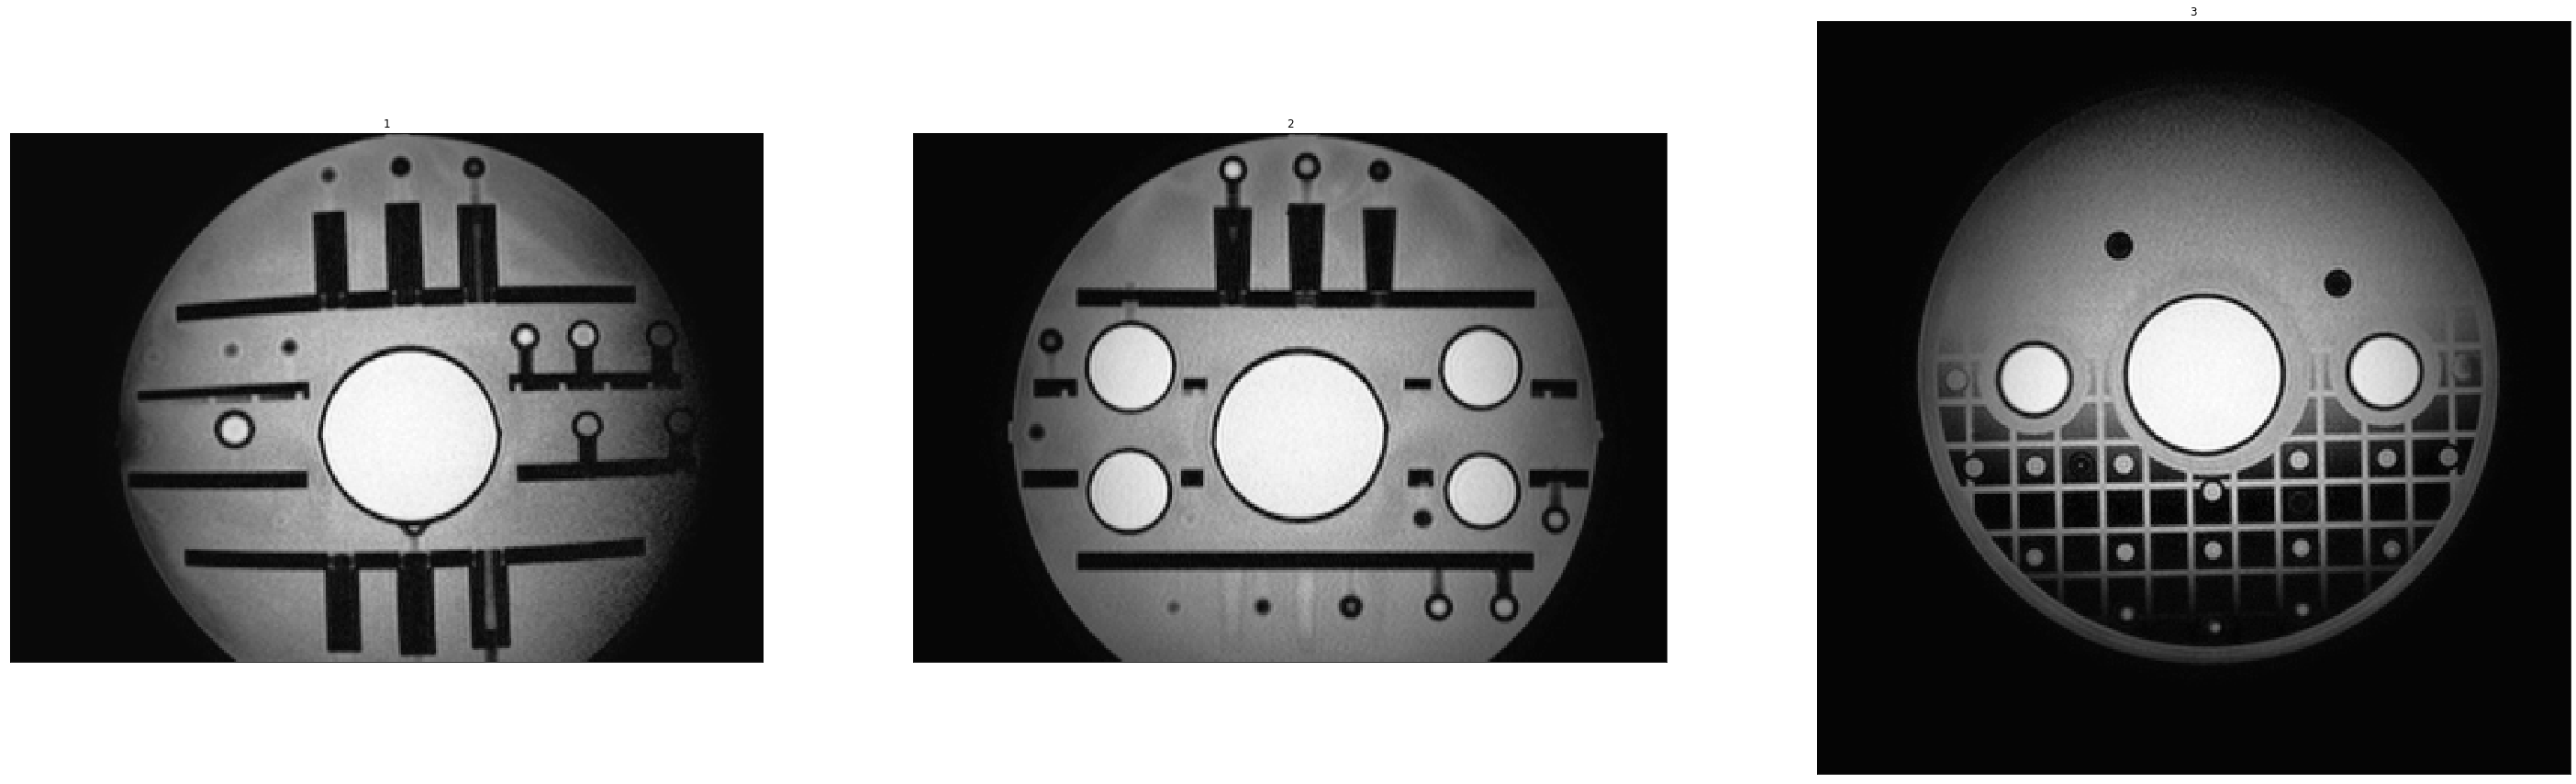

In [20]:
center_vol_plot(gt)

In [38]:
lr_obj = nib.load(fnames[1])
lr = lr_obj.get_fdata()

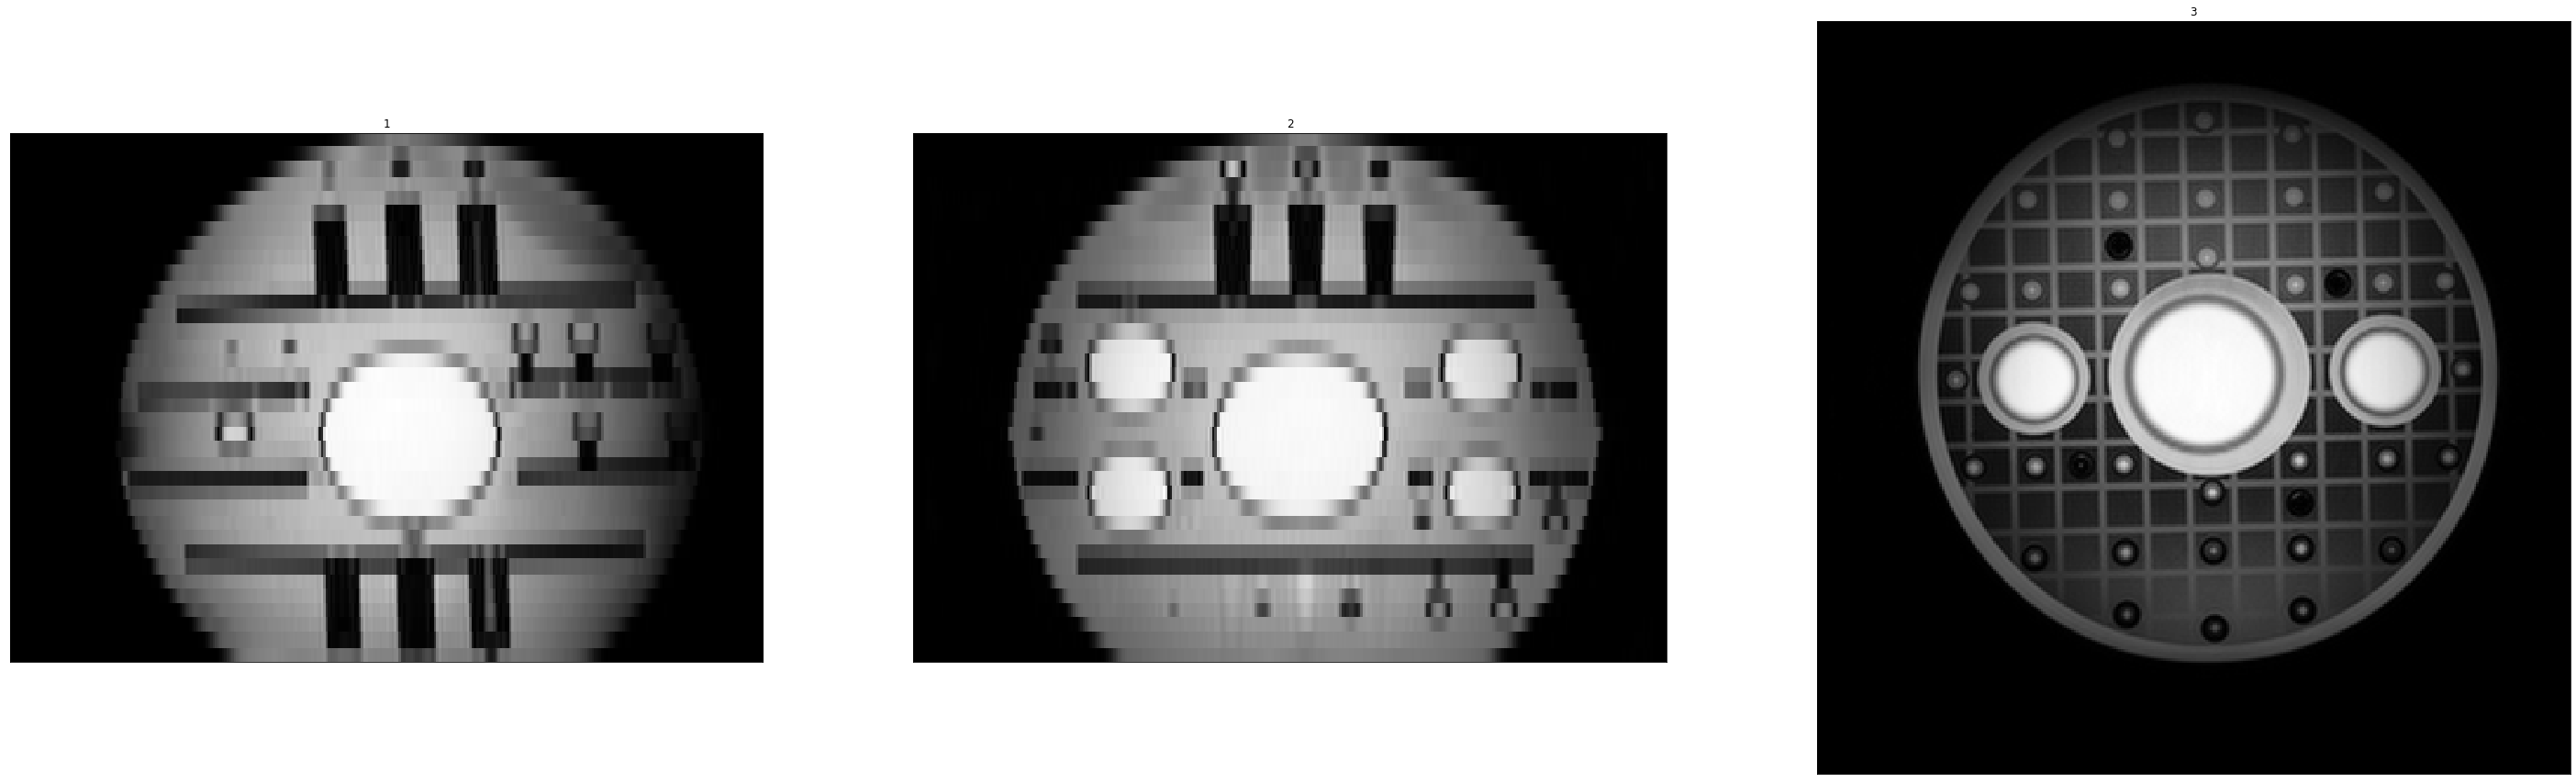

In [39]:
center_vol_plot(lr, gt.shape)

In [40]:
lr_cuda = torch.from_numpy(lr).float().cuda()

In [438]:
imgs_hr, imgs_blurred, imgs_aliased = process_nii_obj(
        lr_obj,
        n_layers=13,
        patch_size=PATCH_SIZE,
        kernel_size=3,
        to_interp=False,
        lr_axis=None,
        k=None,
        n_rots=1,
        n_cores=1,
        acq_dim=2,
        train=True,
        window_option=None,
        verbose=True,
    )

========== PREPROCESSING IMAGE ==========
Rotating in-plane 1 times...
	Elapsed time to get rotations: 0.7350s
Applying blur to rotated images...
	Elapsed time to apply blur: 0.0967s
Applying aliasing to blurred images...
	Elapsed time to apply aliasing: 1.0221s
========== PREPROCESSING FINISHED ==========
	Elapsed time to preprocess: 1.8982s


In [439]:
def get_training_pair(
        views_list_x,
        views_list_y,
        index_iter,
        patch_size,
        batch_size,
        n_layers,
        kernel_size,
        pad_mode,
        thresh,
        seed,
):

    xs = np.zeros((batch_size, *patch_size), dtype=np.float32)
    ys = np.zeros((batch_size, *patch_size), dtype=np.float32)

    idx_order = list(range(batch_size))
    idx_order = shuffle(idx_order, random_state=seed)
    
    insertion_idx = 0
    
    while insertion_idx < batch_size:
        
        i = next(index_iter)
        # select a random rotation from the list
        rot_idx = np.random.choice(len(views_list_x))
        
        if views_list_y[rot_idx][i].mean() < thresh:
            continue

        # Take copies for the batch to allow augmentation
        x = views_list_x[rot_idx][i].copy()
        y = views_list_y[rot_idx][i].copy()

        # random flip along X-axis
        if np.random.choice([True, False]) == True:
            x = x[::-1, ...]
            y = y[::-1, ...]

        # random flip along Y-axis
        if np.random.choice([True, False]) == True:
            x = x[:, ::-1, ...]
            y = y[:, ::-1, ...]

        xs[idx_order[insertion_idx]] = x
        ys[idx_order[insertion_idx]] = y
        
        insertion_idx += 1

    # for torch, move channel dim to position 1
    xs = np.moveaxis(xs, -1, 1)
    ys = np.moveaxis(ys, -1, 1)    
        
    xs = torch.from_numpy(xs).float().cuda()
    ys = torch.from_numpy(ys).float().cuda()

    return xs, ys

In [440]:
PATCH_SIZE = (32, 32, 1)

In [441]:
xs = imgs_aliased
ys = imgs_hr

In [442]:
views_list_x = [view_as_windows(img, PATCH_SIZE) for img in xs]
views_list_y = [view_as_windows(img, PATCH_SIZE) for img in ys]
indices = list(np.ndindex(views_list_y[0].shape[:len(PATCH_SIZE)]))
indices = shuffle(indices, random_state=0)
index_iter = iter(indices)

In [443]:
n_layers = 67
kernel_size = 3

In [444]:
model = EDSR(
    n_channels=1,
    kernel_size=kernel_size,
    n_layers=n_layers,
    filters=128,
    padding_mode='zeros',
).cuda()

In [457]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_obj = l2_sobel_loss

In [458]:
xs, ys = get_training_pair(
    views_list_x,
    views_list_y,
    index_iter,
    patch_size=PATCH_SIZE,
    batch_size=4,
    n_layers=n_layers,
    kernel_size=kernel_size,
    pad_mode='CONSTANT',
    thresh=0.01,
    seed=0,
)

In [462]:
N_STEPS = 1000
with tqdm(total=N_STEPS) as pbar:
    for cur_step in range(N_STEPS):
        
        ys_hat = model(xs)
        loss = loss_obj(ys_hat, ys)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_postfix(loss=loss.item())
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.48it/s, loss=0.000514]


0.057649788


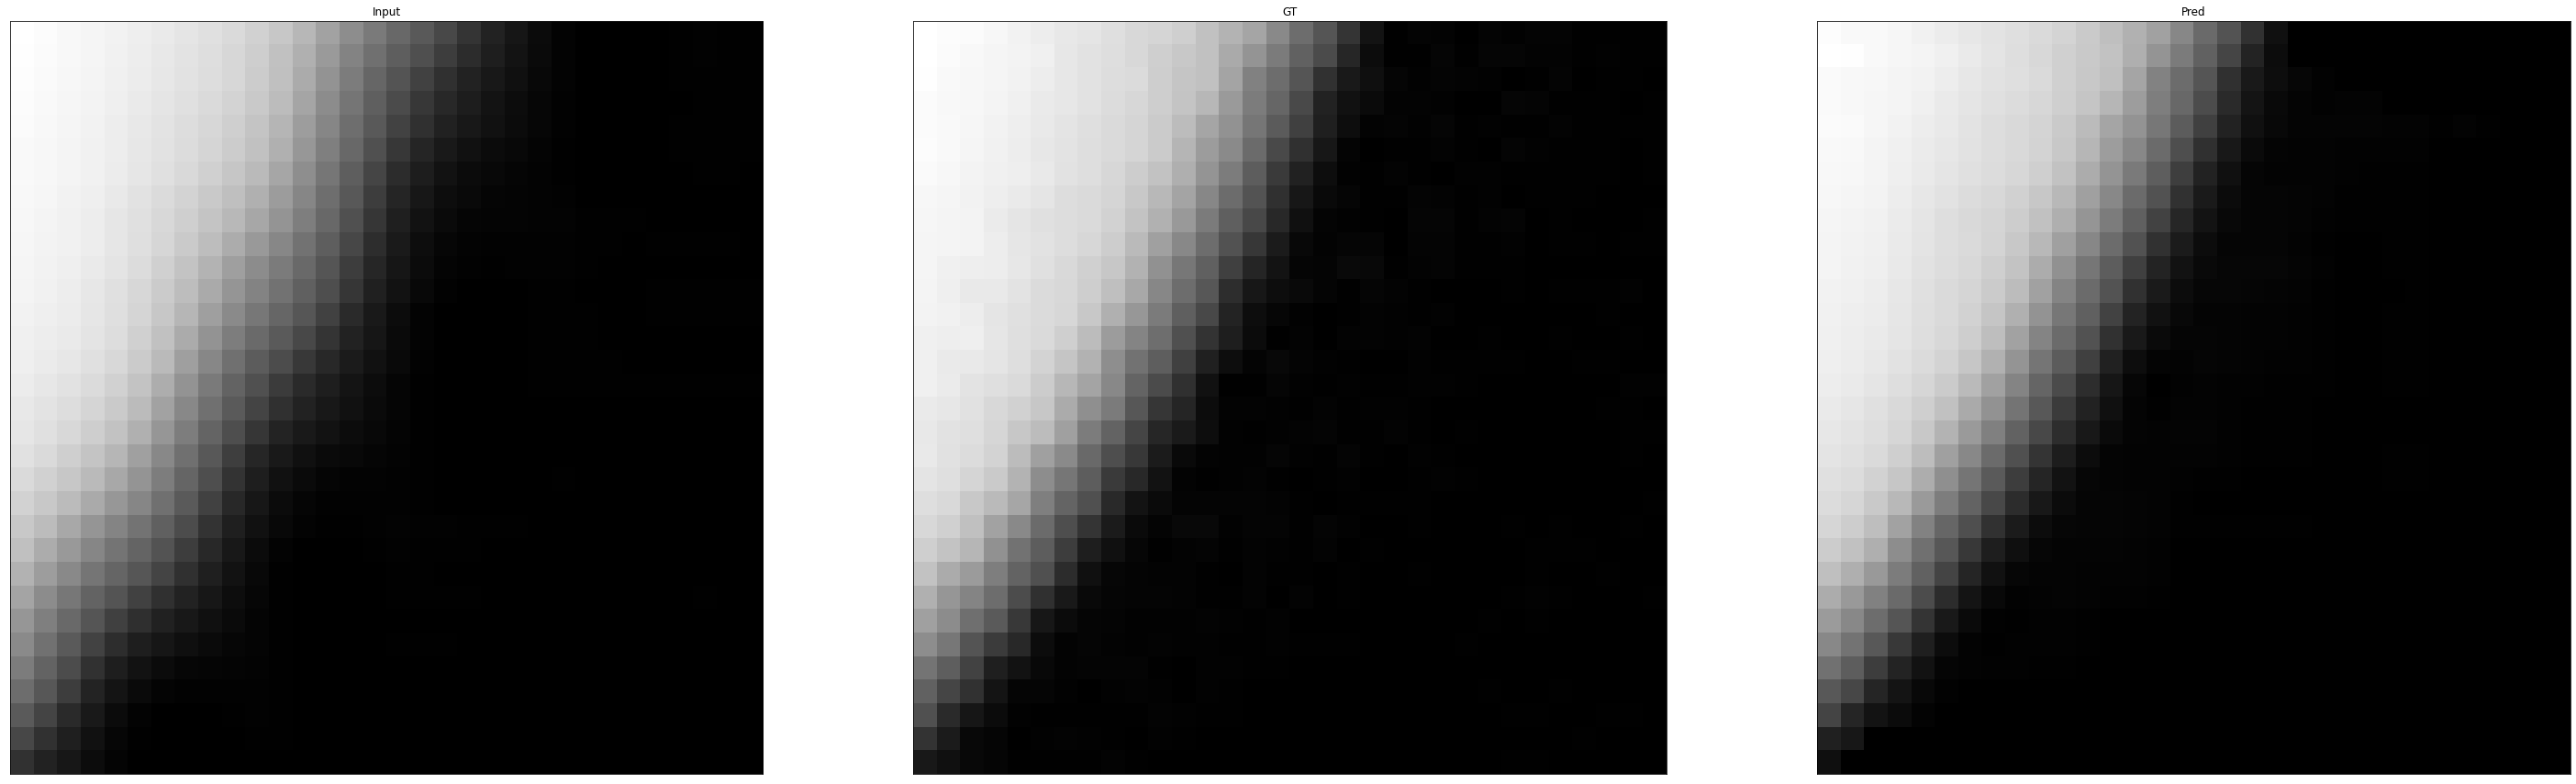

0.12735043


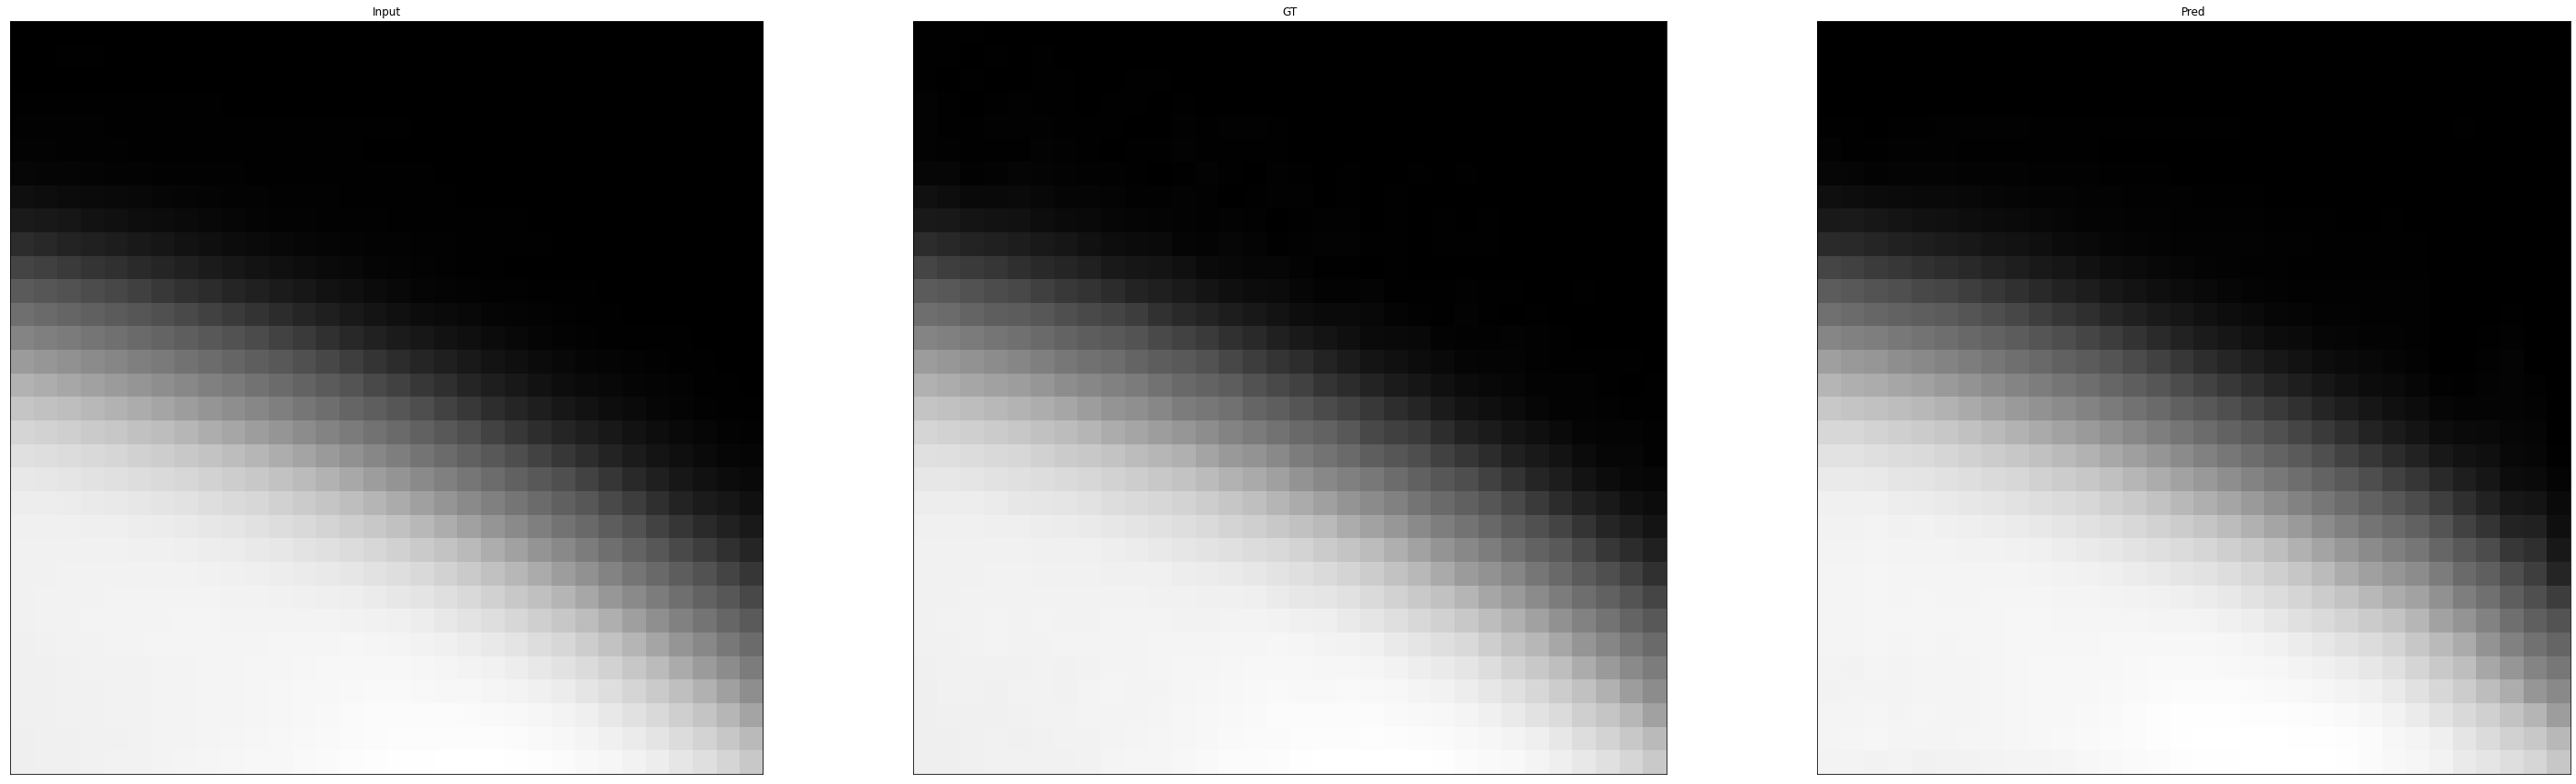

0.1320883


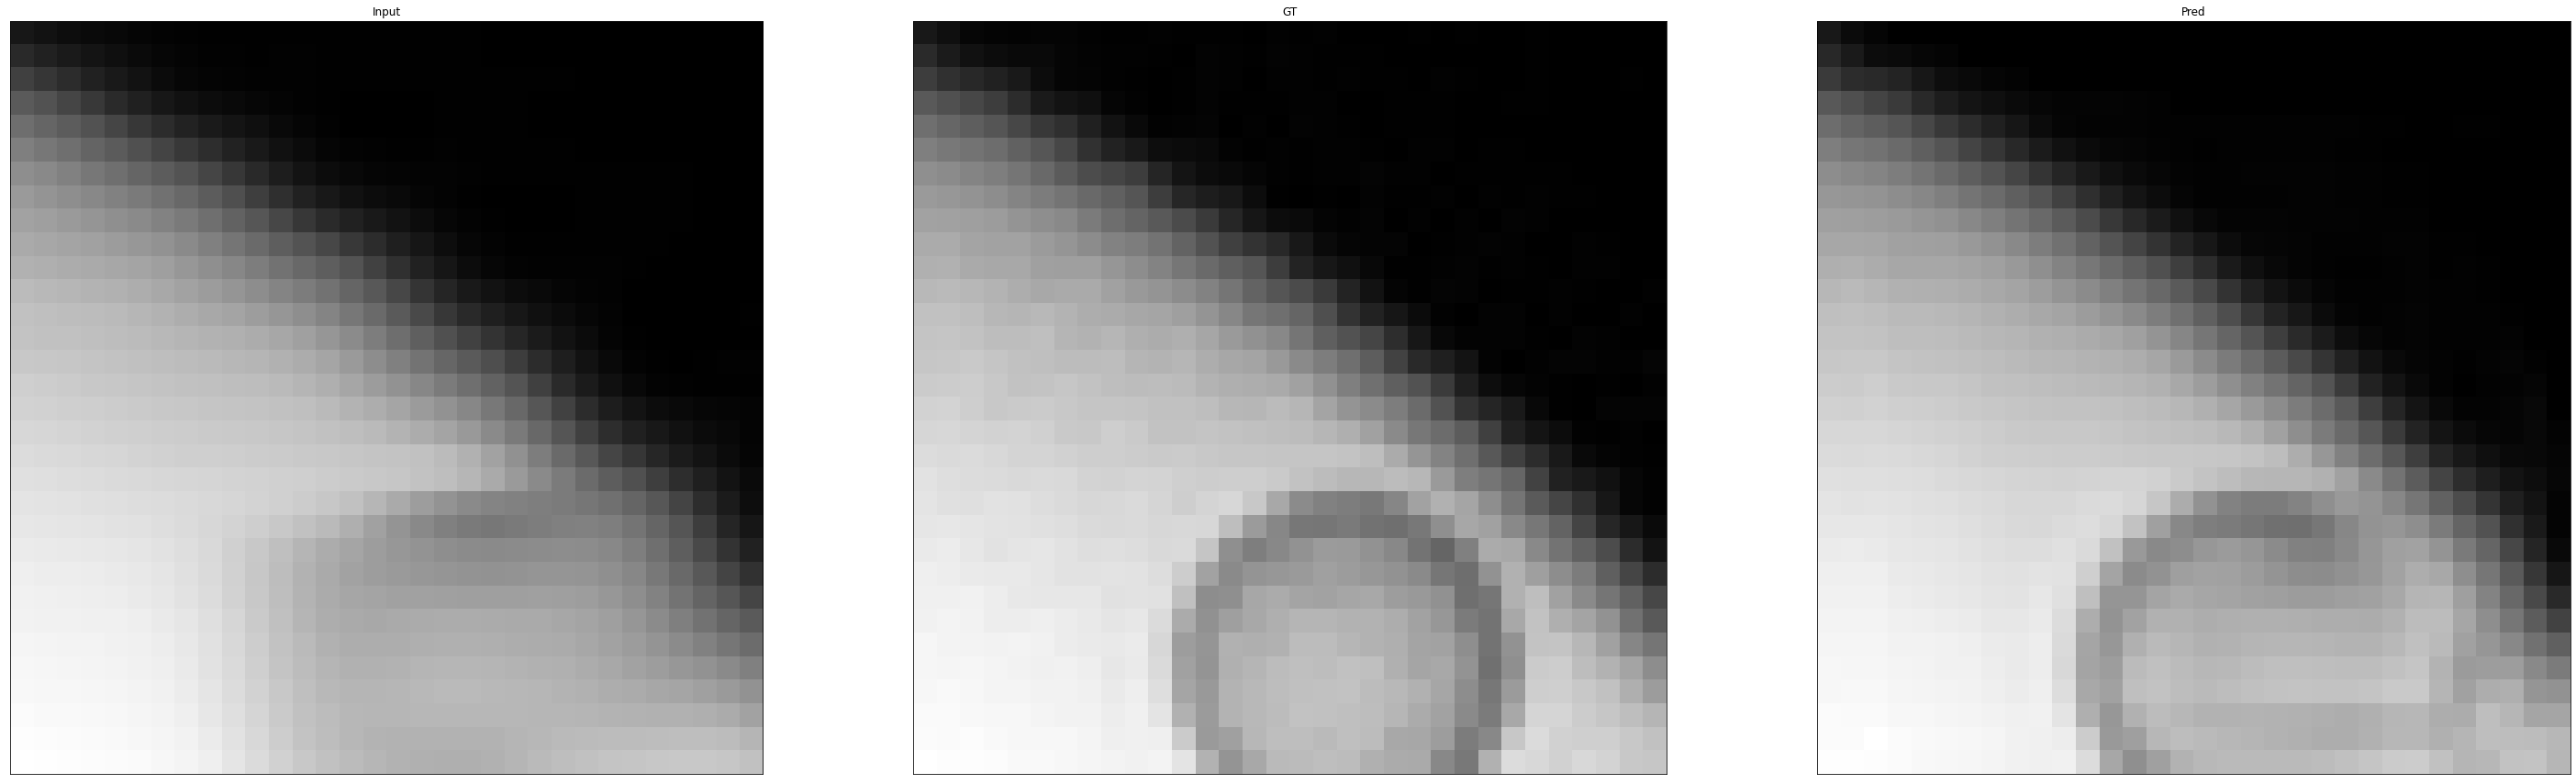

0.06404242


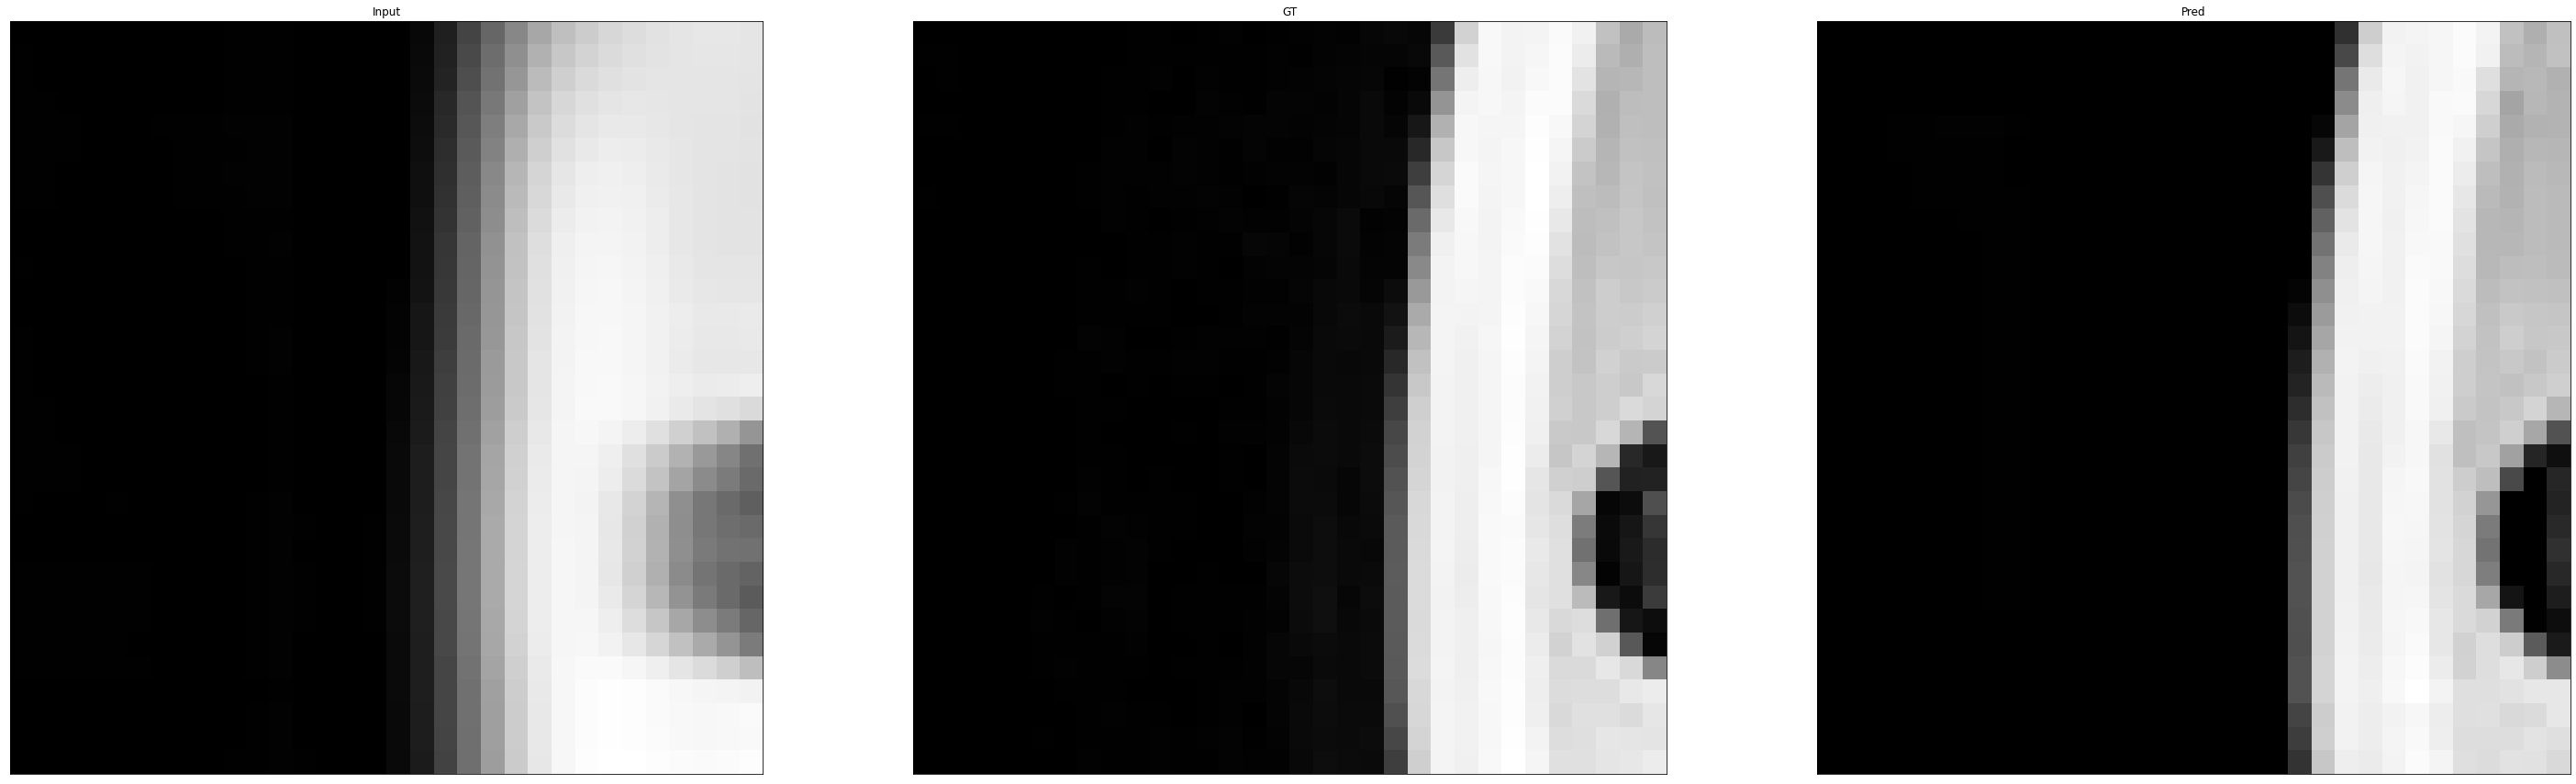

In [463]:
for x, y in zip(xs, ys):
    y_hat = model(x[np.newaxis,...])
    print(y.cpu().numpy().mean())
    multiplot(
        [
            x.cpu().numpy().squeeze(), 
            y.cpu().numpy().squeeze(), 
            y_hat.detach().cpu().numpy().squeeze(),
        ],
        [
            'Input',
            'GT',
            'Pred',
        ]
    )